#**Time series and forecasting problems (Sunspots dataset)**

In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [8]:
#!pip install tensorflow==2.5.0

In [9]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

### Loading the data

In [11]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /content/Sunspots.csv
100% 70.8k/70.8k [00:00<00:00, 80.2MB/s]


### Importing, and reading the data


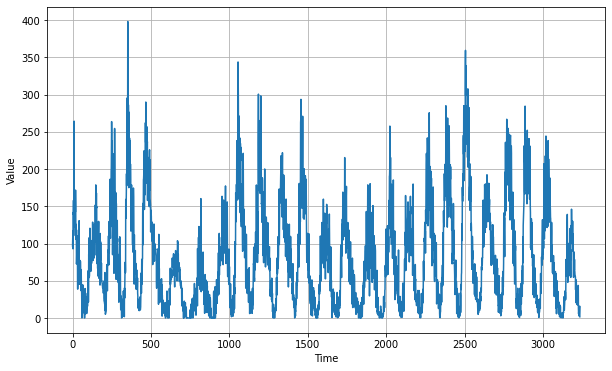

In [12]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

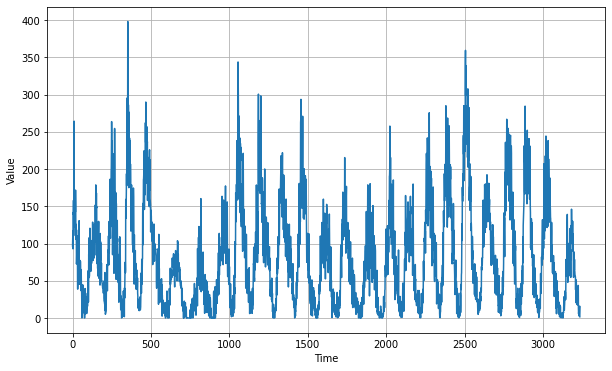

In [13]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

### Splitting the dat

In [14]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Model buildup

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/100
12/12 [==============================] - 13s 55ms/step - loss: 158.7652 - mae: 159.2646 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 35ms/step - loss: 145.2500 - mae: 145.7495 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 67ms/step - loss: 136.8032 - mae: 137.3029 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 70ms/step - loss: 128.4212 - mae: 128.9209 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 38ms/step - loss: 116.3746 - mae: 116.8742 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 85ms/step - loss: 104.0807 - mae: 104.5801 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 36ms/step - loss: 92.4105 - mae: 92.9096 - lr: 1.9953e-08
Epoch 8/100
12/12 [==

### Getting best learning rate

(1e-08, 0.0001, 0.0, 60.0)

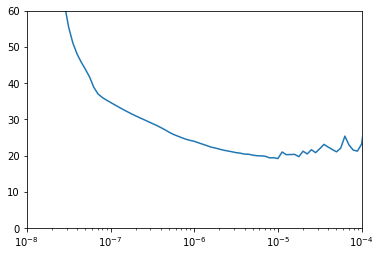

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

### Final training

In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 23ms/step - loss: 52.2762 - mae: 52.7736
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 26.3346 - mae: 26.8296
Epoch 3/500
30/30 [==============================] - 1s 20ms/step - loss: 24.0290 - mae: 24.5233
Epoch 4/500
30/30 [==============================] - 1s 19ms/step - loss: 21.8031 - mae: 22.2966
Epoch 5/500
30/30 [==============================] - 1s 20ms/step - loss: 20.5585 - mae: 21.0515
Epoch 6/500
30/30 [==============================] - 1s 20ms/step - loss: 19.9139 - mae: 20.4068
Epoch 7/500
30/30 [==============================] - 1s 20ms/step - loss: 19.7496 - mae: 20.2427
Epoch 8/500
30/30 [==============================] - 1s 20ms/step - loss: 19.4805 - mae: 19.9730
Epoch 9/500
30/30 [==============================] - 1s 20ms/step - loss: 19.2191 - mae: 19.7118
Epoch 10/500
30/30 [==============================] - 1s 37ms/step - loss: 18.9279 - mae: 19.4203
Epoch 11/500
30/30 [=========

In [20]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

100/100 [==============================] - 2s 9ms/step


#### Behaviour of algorithm

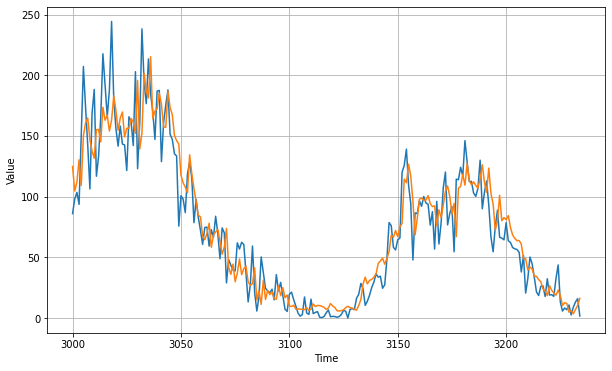

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

### Accuracy result

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.760096

<Figure size 432x288 with 0 Axes>

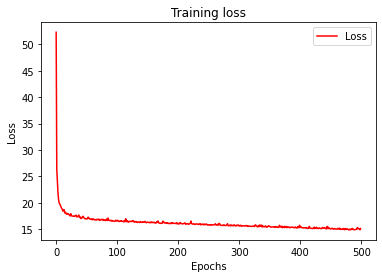

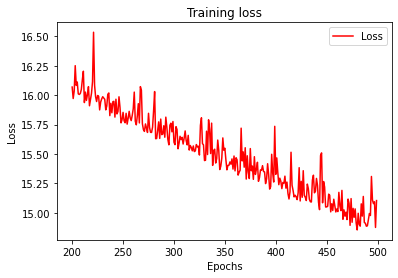

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [24]:
print(rnn_forecast)

[124.822464  104.62475   111.867836  130.27325   109.19826   149.91133
 160.74593   164.798     147.01508   137.40782   131.61069   155.22368
 155.2445    145.04295   173.58296   162.88354   167.12567   154.05054
 163.10738   182.88477   171.00029   154.63715   164.70726   169.67084
 149.07309   156.2479    156.33626   164.40723   161.43207   152.11299
 195.71994   139.24725   152.25487   201.66156   186.58311   181.20697
 215.23383   164.24811   170.45233   172.36646   185.19409   176.04167
 157.28653   157.15161   186.65836   173.2132    167.55177   150.31026
 146.07776   143.24947   117.72177   111.399475  107.89358   103.09472
 134.39937   118.9816    106.549095   95.64224    84.67203    83.3026
  67.26953    64.48384    69.817696   78.05712    58.238007   68.45854
  70.9882     72.935875   62.469776   52.502823   58.564163   73.77011
  41.700893   35.93641    44.41625    29.811584   37.09182    48.56349
  35.68677    40.722374   42.672092   29.706596   26.822094   28.299553
  41.3

##Tuning the model to achieve MAE <14.5

In [25]:
split_time = 3040
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000


In [26]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [27]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### Model Building

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3040,)
Epoch 1/100
12/12 [==============================] - 5s 52ms/step - loss: 85.6501 - mae: 86.1452 - lr: 1.0000e-08
Epoch 2/100
12/12 [==============================] - 1s 33ms/step - loss: 85.2915 - mae: 85.7869 - lr: 1.1220e-08
Epoch 3/100
12/12 [==============================] - 1s 36ms/step - loss: 84.7759 - mae: 85.2719 - lr: 1.2589e-08
Epoch 4/100
12/12 [==============================] - 1s 37ms/step - loss: 84.1603 - mae: 84.6572 - lr: 1.4125e-08
Epoch 5/100
12/12 [==============================] - 1s 34ms/step - loss: 83.4447 - mae: 83.9421 - lr: 1.5849e-08
Epoch 6/100
12/12 [==============================] - 1s 36ms/step - loss: 82.5542 - mae: 83.0521 - lr: 1.7783e-08
Epoch 7/100
12/12 [==============================] - 1s 43ms/step - loss: 81.3650 - mae: 81.8632 - lr: 1.9953e-08
Epoch 8/100
12/12 [===============

### Finding best learning rate

(1e-08, 0.0001, 0.0, 60.0)

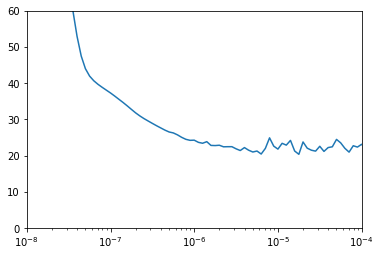

In [29]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

### Tuning the final model

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 20ms/step - loss: 66.5873 - mae: 67.0855
Epoch 2/500
30/30 [==============================] - 1s 20ms/step - loss: 45.6429 - mae: 46.1407
Epoch 3/500
30/30 [==============================] - 1s 21ms/step - loss: 33.8397 - mae: 34.3358
Epoch 4/500
30/30 [==============================] - 1s 20ms/step - loss: 30.5333 - mae: 31.0289
Epoch 5/500
30/30 [==============================] - 1s 21ms/step - loss: 25.7670 - mae: 26.2616
Epoch 6/500
30/30 [==============================] - 1s 21ms/step - loss: 26.3562 - mae: 26.8507
Epoch 7/500
30/30 [==============================] - 1s 36ms/step - loss: 25.7630 - mae: 26.2577
Epoch 8/500
30/30 [==============================] - 1s 20ms/step - loss: 26.2539 - mae: 26.7488
Epoch 9/500
30/30 [==============================] - 1s 20ms/step - loss: 25.4382 - mae: 25.9324
Epoch 10/500
30/30 [==============================] - 1s 21ms/step - loss: 24.4615 - mae: 24.9556
Epoch 11/500
30/30 [=========

### Forecasting

In [31]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

100/100 [==============================] - 2s 9ms/step


### Plotting forecasting plot

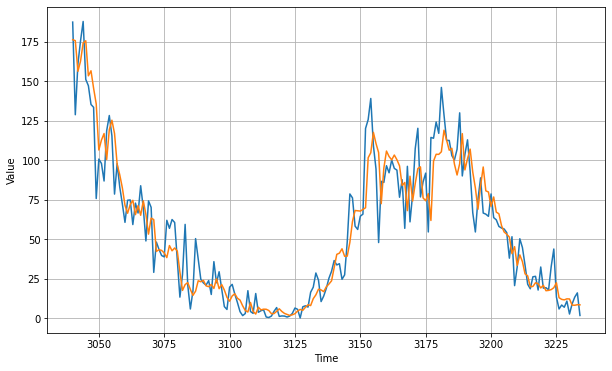

In [32]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

### Accuracy Result

In [33]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

11.375189

In [34]:
### plotting the traing loss

<Figure size 432x288 with 0 Axes>

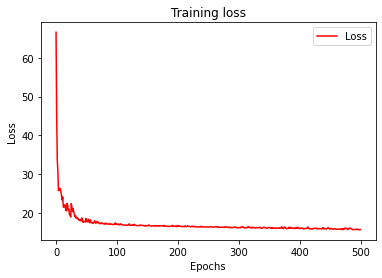

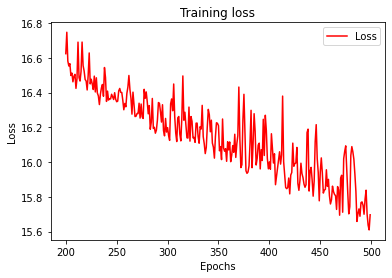

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [36]:
print(rnn_forecast)

[176.37355   175.71233   156.29573   162.81271   174.1976    175.66928
 153.46426   156.65096   145.56618   135.62914   106.43775   112.75039
 116.87175   100.42373   119.34216   125.3217    116.924576   97.44402
  90.69389    82.37976    71.4158     66.36617    71.900345   74.55691
  65.466805   71.19246    65.08888    74.25516    65.56884    53.127487
  63.29056    62.359936   42.190712   43.298798   42.82287    41.22521
  38.256237   45.89863    42.560394   44.362247   42.433212   29.20794
  17.481781   21.157492   22.41168    18.13153    14.342284   16.991955
  23.562912   22.956472   23.816658   20.371199   19.824684   21.235863
  18.717436   24.887287   18.560696   21.170822   17.703596   13.085979
  10.618586   13.987607   15.327305   12.525502   11.318838    7.709461
   4.7521534   3.7701428   9.826618    4.1585865   2.4825633   6.8132105
   5.1224413   5.575025    5.524862    4.737401    2.7294397   2.8014302
   4.204911    5.8123884   4.116803    2.8892457   2.2396386   1.591